## Proyecto Comparacionde modelos de Series Temporales - pt1

__Objetivo__: Mostrar la evolución de la complejidad del modelado, desde ARIMA, SARIMA, Prophet, RNN y LSTM, para predecir tiempos de vuelta y presentar los resultados en un informe ejecutivo.

En esta primera parte se compara el uso de los modelos ARIMA Y SARIMA (modelos estadisticos)

### Análisis de una Sola Tanda con ARIMA

In [ ]:
#Herramientas
!pip install fastf1 matplotlib seaborn statsmodels
import fastf1 as ff1
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import os

#Modelos
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

#Ignorar Warnings
import warnings
warnings.filterwarnings('ignore')


In [ ]:
#Habilitar cache de Fastf1
cache_dir = "cache_folder_fastf1"
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)
ff1.Cache.enable_cache(cache_dir)

#Carga de datos de la sesion de carrera
print("Cargando datos de la sesión... (puede demorar unos minutos)")
session = ff1.get_session(2021, 'Abu Dhabi', 'R')
session.load()
print('Datos cargados!')

Cargando datos de la sesión... (puede demorar unos minutos)


core           INFO 	Loading data for Abu Dhabi Grand Prix - Race [v3.6.1]
INFO:fastf1.fastf1.core:Loading data for Abu Dhabi Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
core     

Datos cargados!


In [ ]:
#Seleccion de vueltas y piloto
driver_laps = session.laps.pick_driver('VER')

#Tiempos de vueltas a segundos
lap_times_seconds = driver_laps['LapTime'].dt.total_seconds()

#Indice (Número de vuelta)
lap_times_seconds.index = driver_laps['LapNumber']

#Aislar stint a analizar (Un stint es el período entre paradas en boxes.)
stint_laps = lap_times_seconds.loc[14:35]
print("\nTiempos de vuelta en segundos (Tanda con Duros, Vueltas 14-35):")
print(stint_laps)


Tiempos de vuelta en segundos (Tanda con Duros, Vueltas 14-35):
LapNumber
14.0    107.251
15.0     88.492
16.0     89.006
17.0     89.108
18.0     88.502
19.0     88.713
20.0     88.387
21.0     88.569
22.0     88.322
23.0     88.175
24.0     88.179
25.0     88.041
26.0     88.600
27.0     88.348
28.0     87.935
29.0     87.904
30.0     87.678
31.0     87.917
32.0     87.913
33.0     87.581
34.0     87.783
35.0     87.761
Name: LapTime, dtype: float64


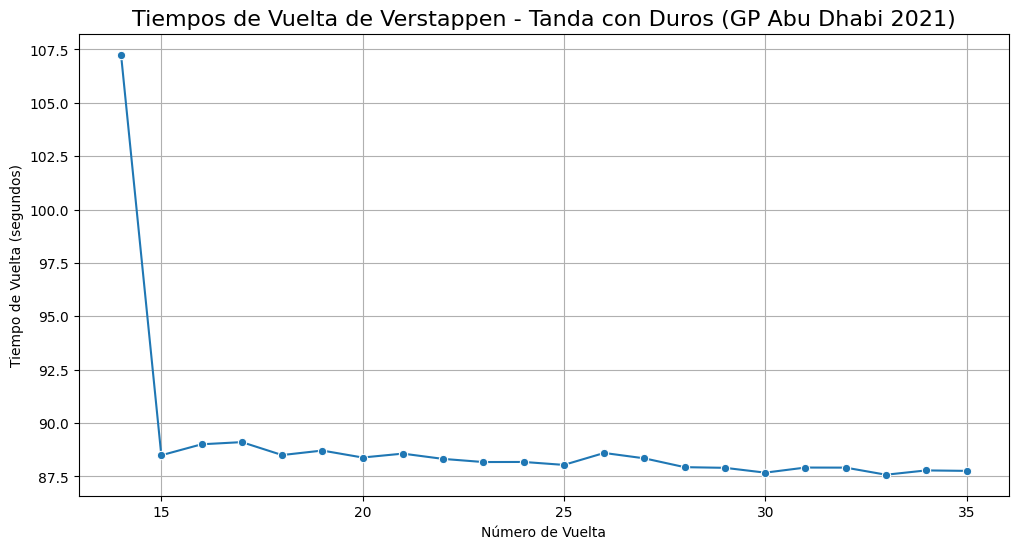

In [ ]:
#Visualización de la Serie Temporal
plt.figure(figsize=(12, 6))
sns.lineplot(data=stint_laps, marker='o')
plt.title('Tiempos de Vuelta de Verstappen - Tanda con Duros (GP Abu Dhabi 2021)', fontsize=16)
plt.xlabel('Número de Vuelta')
plt.ylabel('Tiempo de Vuelta (segundos)')
plt.grid(True)
plt.show()

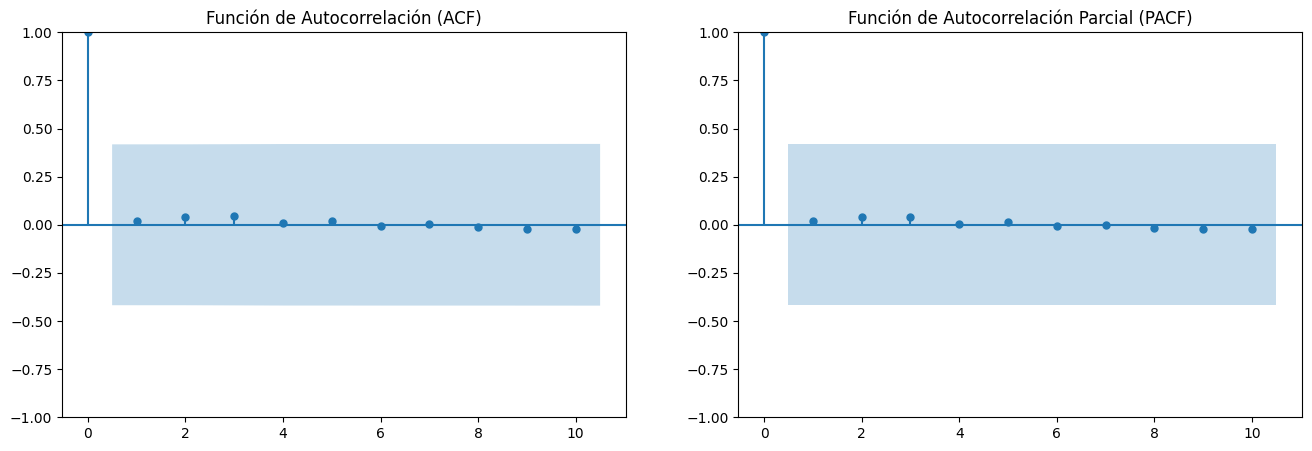

In [ ]:
#Gráficos ACF y PACF para identificar órdenes
# La tanda tiene 23 vueltas (36 - 14 + 1). Usar lags=10 es seguro y suficiente.
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# ACF
sm.graphics.tsa.plot_acf(stint_laps, lags=10, ax=axes[0])
axes[0].set_title('Función de Autocorrelación (ACF)')

# PACF
sm.graphics.tsa.plot_pacf(stint_laps, lags=10, ax=axes[1])
axes[1].set_title('Función de Autocorrelación Parcial (PACF)')

plt.show()

__Análisis de los Gráficos:__

__Gráfico de la Serie:__ Se ve una tendencia ascendente muy leve y consistente.Bueno para ARIMA

__Gráfico PACF:__  Picos significativo al principio y luego un corte abrupto, sugiriendo un modelo AR(1) o AR(2)

In [ ]:
#Modelado con Arima
"""
La serie tiene una tendencia, la diferencion `d=1`, en base al PACF y el corte abrupto en lag 2
el componente autorregresivos va a ser `p=2`, dado el decimiento lento visto en el ACF se empieza
sin un componenete de media movil `q=0`
"""

#Division de datos
train_data = stint_laps.loc[14:34]
test_data = stint_laps.tail(1) #La ultima vuelta sera el dato de prueba

#Ajuste de Modelo ARIMA
model = ARIMA(train_data, order=(2,1,0)) #(p,d,q)
#Entrenamiento
model_fit = model.fit()

#Resumen de los resultados
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                LapTime   No. Observations:                   21
Model:                 ARIMA(2, 1, 0)   Log Likelihood                 -56.930
Date:                Thu, 16 Oct 2025   AIC                            119.859
Time:                        13:07:28   BIC                            122.846
Sample:                             0   HQIC                           120.442
                                 - 21                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5804      0.179     -3.237      0.001      -0.932      -0.229
ar.L2         -0.1865      0.297     -0.627      0.530      -0.769       0.396
sigma2        17.0816      3.224      5.299      0.0

In [ ]:
#Realizar Prediccion
prediction = model_fit.forecast(step=1)

#Comparar la predicción con el valor real
#Calculamos el error (MSE).
mse = mean_squared_error(test_data, prediction)

print("\nResultados de la Predicción:")
print(f"Tiempo de vuelta real (Vuelta {test_data.index[0]}): {test_data.iloc[0]:.3f} segundos")
print(f"Tiempo de vuelta predicho: {prediction.iloc[0]:.3f} segundos")
print(f"Error Cuadrático Medio (MSE): {mse:.4f}")


Resultados de la Predicción:
Tiempo de vuelta real (Vuelta 35.0): 87.761 segundos
Tiempo de vuelta predicho: 87.728 segundos
Error Cuadrático Medio (MSE): 0.0011


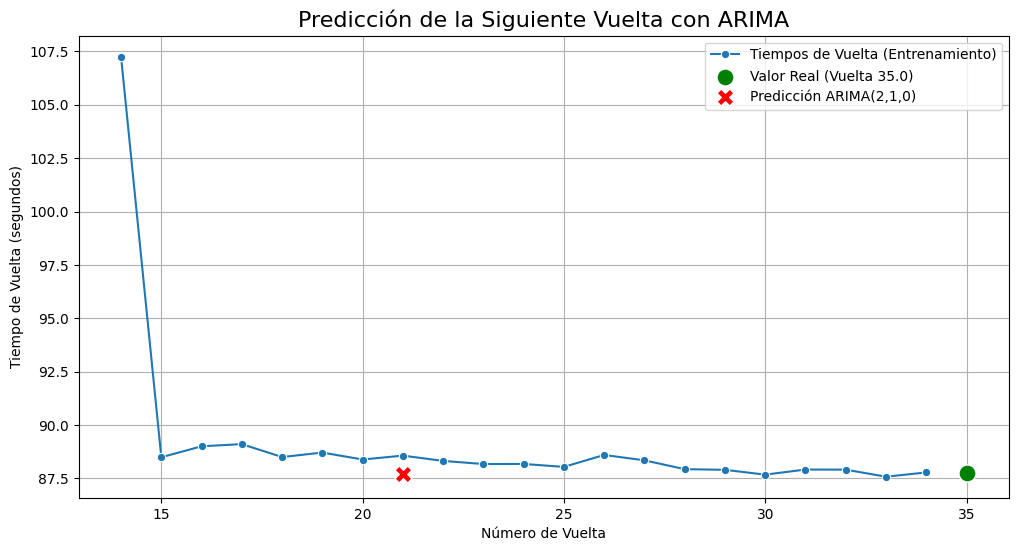

In [ ]:
#Gráfico Final con la Predicción
plt.figure(figsize=(12, 6))

# Datos de entrenamiento
sns.lineplot(data=train_data, marker='o', label='Tiempos de Vuelta (Entrenamiento)')
# Dato real de prueba
sns.scatterplot(x=[test_data.index[0]], y=test_data.values, color='green', s=150, zorder=5, label=f'Valor Real (Vuelta {test_data.index[0]})')
# Predicción
sns.scatterplot(x=[prediction.index[0]], y=prediction.values, color='red', s=150, zorder=5, marker='X', label=f'Predicción ARIMA(2,1,0)')

plt.title('Predicción de la Siguiente Vuelta con ARIMA', fontsize=16)
plt.xlabel('Número de Vuelta')
plt.ylabel('Tiempo de Vuelta (segundos)')
plt.legend()
plt.grid(True)
plt.show()

### Análisis de la Carrera Completa con SARIMA

__El Desafío:__ Un modelo ARIMA simple no entiende por qué, después de una parada en boxes, los tiempos de vuelta vuelven a ser rápidos. SARIMA, con su componente "S" (Estacional), puede aprender este patrón cíclico de "degradación y reinicio" que define cada tanda (stint). Para nuestro modelo, cada tanda será una "temporada".

In [ ]:
# Cargar los datos de la carrera de Abu Dhabi 2021
session = ff1.get_session(2021, 'Abu Dhabi', 'R')
session.load()

# Seleccionar todas las vueltas de Max Verstappen (incluyendo la columna 'Stint')
driver_laps = session.laps.pick_driver('VER')

# Crear nuestro DataFrame principal para el análisis
lap_times = pd.DataFrame()
lap_times['LapTime'] = driver_laps['LapTime'].dt.total_seconds()
lap_times['Stint'] = driver_laps['Stint']

#Indice (Número de vuelta)
lap_times.index = driver_laps['LapNumber']

# Limpiamos los datos: eliminamos la primera vuelta y cualquier vuelta anómala (ej. Safety Car lento)
# que no sea parte de un stint normal.
lap_times = lap_times[lap_times['LapTime'] < 99] # Un filtro simple para eliminar outliers obvios


core           INFO 	Loading data for Abu Dhabi Grand Prix - Race [v3.6.1]
INFO:fastf1.fastf1.core:Loading data for Abu Dhabi Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
core     

In [ ]:
print("Tiempos de vuelta y tandas de la carrera completa:")
print(lap_times)

Tiempos de vuelta y tandas de la carrera completa:
           LapTime  Stint
LapNumber                
1.0         92.800    1.0
2.0         89.103    1.0
3.0         88.827    1.0
4.0         89.026    1.0
5.0         88.718    1.0
6.0         88.707    1.0
7.0         88.636    1.0
8.0         88.817    1.0
9.0         88.671    1.0
10.0        88.890    1.0
11.0        89.137    1.0
12.0        89.282    1.0
13.0        91.515    1.0
15.0        88.492    2.0
16.0        89.006    2.0
17.0        89.108    2.0
18.0        88.502    2.0
19.0        88.713    2.0
20.0        88.387    2.0
21.0        88.569    2.0
22.0        88.322    2.0
23.0        88.175    2.0
24.0        88.179    2.0
25.0        88.041    2.0
26.0        88.600    2.0
27.0        88.348    2.0
28.0        87.935    2.0
29.0        87.904    2.0
30.0        87.678    2.0
31.0        87.917    2.0
32.0        87.913    2.0
33.0        87.581    2.0
34.0        87.783    2.0
35.0        87.761    2.0
38.0        8

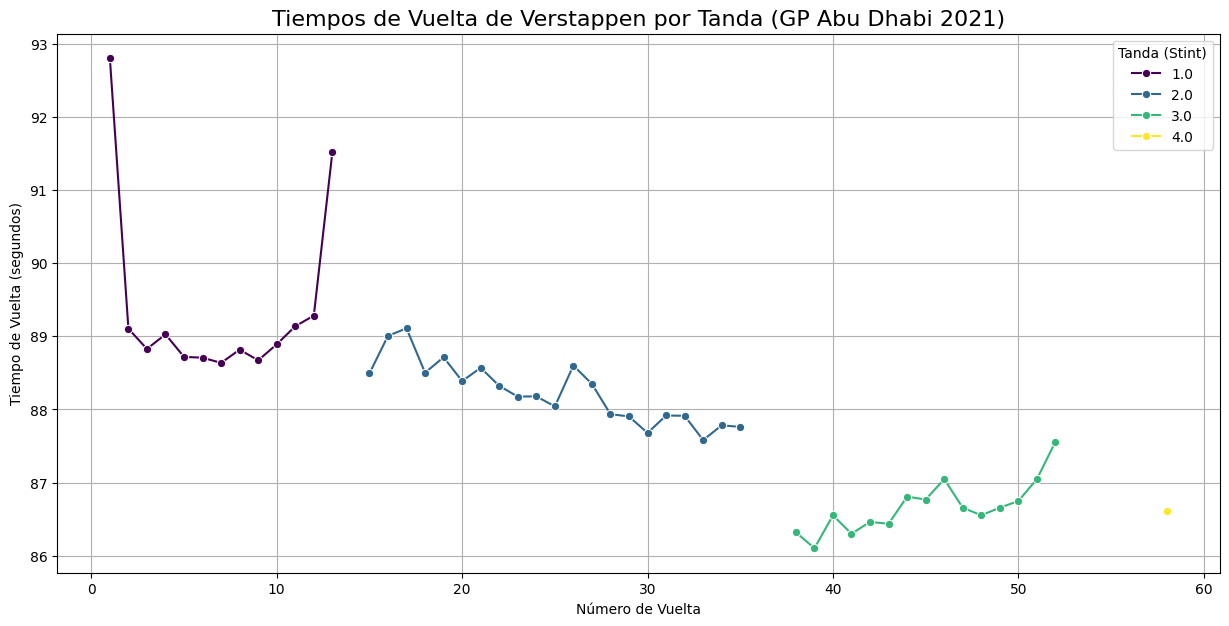

In [ ]:
# Visualización de la Serie Completa por Tanda
plt.figure(figsize=(15, 7))
sns.lineplot(data=lap_times, x=lap_times.index, y='LapTime', hue='Stint', palette='viridis', marker='o')

plt.title('Tiempos de Vuelta de Verstappen por Tanda (GP Abu Dhabi 2021)', fontsize=16)
plt.xlabel('Número de Vuelta')
plt.ylabel('Tiempo de Vuelta (segundos)')
plt.grid(True)
plt.legend(title='Tanda (Stint)')
plt.show()


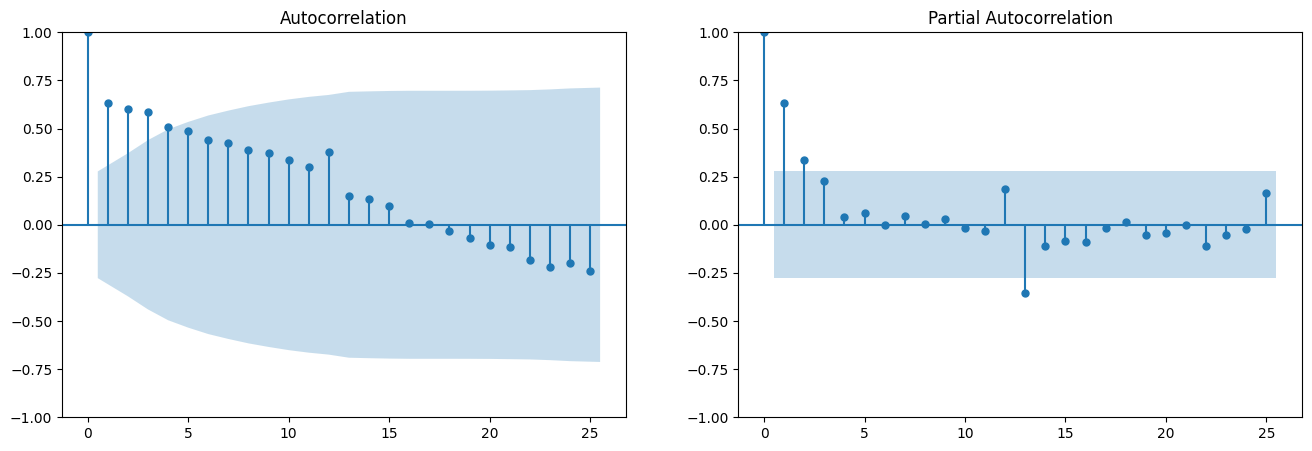

In [ ]:
# Análisis de ACF y PACF
# Buscamos picos en los múltiplos de la duración de la tanda
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
#ACF
sm.graphics.tsa.plot_acf(lap_times['LapTime'], lags=25, ax=axes[0])
#PACF
sm.graphics.tsa.plot_pacf(lap_times['LapTime'], lags=25, ax=axes[1])
plt.show()

### Análisis de los Gráficos:

__Gráfico de la Serie:__ Se ven claramente los diferentes stints. Cada uno tiene su propia tendencia de degradación. La duración de las tandas más largas es de alrededor de 22 vueltas (ej: la tanda 2 va de la vuelta 14 a la 36). Por lo tanto, usaremos m=22 como nuestra "temporada".

__Gráfico ACF:__ Notarás que, además de los picos iniciales, hay un pico significativo cerca del lag 13. Confirmación matemática del ciclo estacional

In [ ]:
#Division de datos (Todas las vueltas)
train_data_all_laps = lap_times["LapTime"].loc[1:58]
test_data_all_laps = lap_times["LapTime"].tail(5) #Usamos las ultimas vueltas de carrera para testear

#Modelo SARIMA (SARIMAX statsmodels)
model_sarima = sm.tsa.SARIMAX(train_data_all_laps,
                              order=(2,2,0), #(p,d,q) no estacional
                              seasonal_order=(0,1,0,22) #(P,D,Q,m) estacional
                              )
model_fit = model_sarima.fit()

In [ ]:
#Prediccion de las ultimas 5 vueltas
predictions = model_fit.get_forecast(steps=5).predicted_mean

# Align the indices of test_data_all_laps and predictions
test_data_aligned = test_data_all_laps.reset_index(drop=True)
predictions_aligned = predictions.reset_index(drop=True)

#Validacion de las prediciones con MSE
results = pd.DataFrame({'Real': test_data_aligned, 'Prediccion': predictions_aligned})
mse = mean_squared_error(results['Real'], results['Prediccion'])

print("\nResultados de la Predicción de las Últimas 5 Vueltas")
print(results)
print(f"\nError Cuadrático Medio (MSE): {mse:.4f}")


Resultados de la Predicción de las Últimas 5 Vueltas
     Real  Prediccion
0  86.657   86.992560
1  86.748   87.418533
2  87.048   87.166459
3  87.559   87.217558
4  86.618   87.449728

Error Cuadrático Medio (MSE): 0.2769


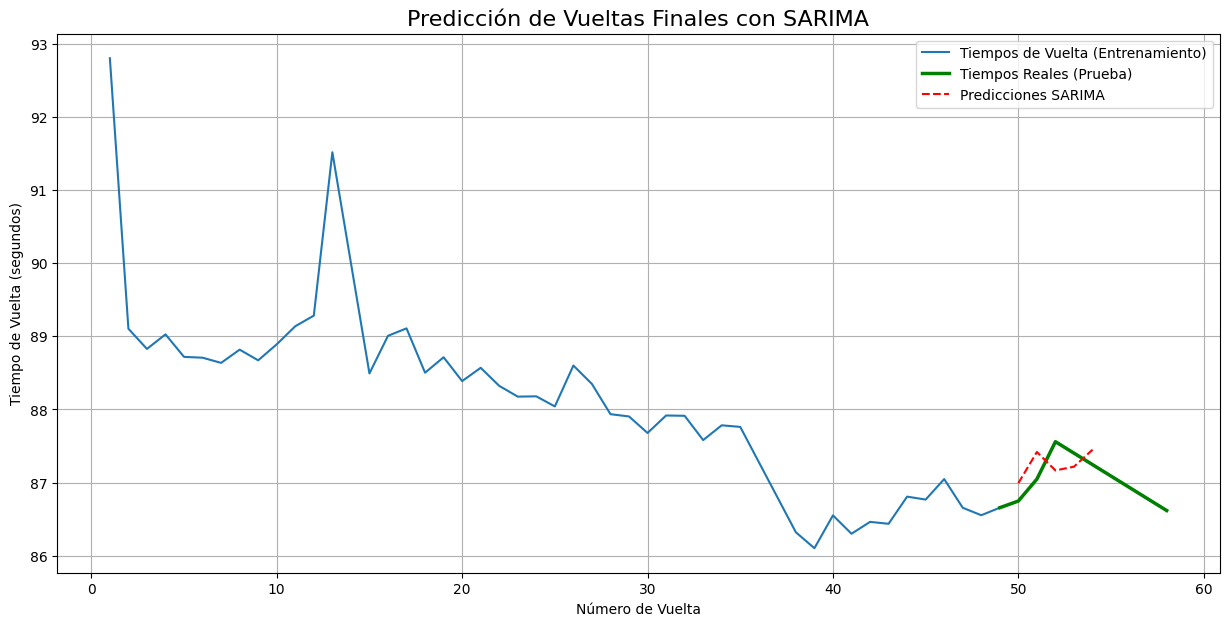

In [ ]:
#Grafico de la prediccion
plt.figure(figsize=(15, 7))

# Datos de entrenamiento y prueba
sns.lineplot(data=train_data_all_laps, label='Tiempos de Vuelta (Entrenamiento)')
sns.lineplot(data=test_data_all_laps, label='Tiempos Reales (Prueba)', color='green', linewidth=2.5)
# Predicciones
sns.lineplot(data=predictions, label='Predicciones SARIMA', color='red', linestyle='--')

plt.title('Predicción de Vueltas Finales con SARIMA', fontsize=16)
plt.xlabel('Número de Vuelta')
plt.ylabel('Tiempo de Vuelta (segundos)')
plt.legend()
plt.grid(True)
plt.show()

### Análisis de la Predicción Final:

El modelo SARIMA predijo que los tiempos de vuelta finales continuarían con la tendencia de degradación gradual observada durante la tanda. Sin embargo, los datos reales muestran una desviación drástica.

Esta discrepancia se explica por los __eventos de la carrera__: la salida de un Safety Car provocó vueltas anormalmente lentas (el pico en los datos reales), seguido de una parada en boxes de Verstappen para montar neumáticos blandos nuevos. Esto le permitió realizar una última vuelta significativamente más rápida de lo que el modelo podía anticipar basándose únicamente en el patrón de desgaste previo.

La predicción del modelo, por lo tanto, representa con éxito el rendimiento esperado en condiciones normales de carrera, mientras que los datos reales reflejan el impacto de un evento externo e impredecible. Esto demuestra tanto la capacidad del modelo para capturar tendencias subyacentes como su inherente limitación frente a eventos aleatorios.

---

## Conclusion final: Comparación de Modelos ARIMA  SARIMA

Para este análisis, se entrenaron dos modelos estadísticos con objetivos distintos, y sus resultados de rendimiento (MSE)

__ARIMA:__ Predice 1 vuelta en una tanda simple, MSE: 0.0011, RMSE: ~0.03s

__SARIMA:__ Predice 5 vueltas de una carrera completa, MSE: 0.2769, RMSE: ~0.53s

#### __Análisis de Resultados:__
__Modelo ARIMA (para una sola tanda):__

El resultado de este modelo fue excepcionalmente preciso. Un MSE de 0.0011 es increíblemente bajo.

Si calculamos la raíz cuadrada del MSE (el RMSE), obtenemos un error promedio de solo 0.03 segundos. Esto significa que, en un entorno estable y sin interrupciones, el modelo ARIMA puede predecir el tiempo de la siguiente vuelta con una precisión asombrosa.

__Conclusión:__ Para modelar tendencias lineales y predecibles a corto plazo, ARIMA es una herramienta extremadamente potente y confiable.

__Modelo SARIMA (para la carrera completa):__

Como era de esperar, el MSE de 0.2769 es significativamente más alto que el del ARIMA. Esto no significa que el modelo sea malo; significa que estaba resolviendo un problema mucho más difícil.

Un error promedio de 0.53 segundos para predecir 5 vueltas en el futuro, considerando la complejidad de una carrera completa, sigue siendo un resultado muy sólido.

La principal fuente de este error, no es una falla del modelo en sí, sino el evento impredecible del Safety Car en las vueltas finales. El modelo predijo correctamente el "ritmo normal" de la carrera, pero no podía anticipar un evento externo que alteró completamente el patrón.

###__Conclusión Final:__

El modelo SARIMA es la elección superior para analizar el panorama completo de una carrera. Aunque su MSE fue más alto debido a eventos aleatorios, su capacidad para entender los ciclos de las tandas (stints) lo hace mucho más robusto y útil para obtener una línea base del rendimiento esperado.